## Experiment GOTA net

In [1]:
import os
import numpy as np
import seaborn as sns
import cv2 as cv

import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import L2
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [2]:
tree_types = os.listdir('../data/image data/train')
X = []
y = []
val_x = []
val_y = []

for tree in tree_types:
    tree_path = os.path.join('../data/image data/train', tree)
    tree_disease_types = os.listdir(tree_path)

    for disease in tree_disease_types:
        img_name = os.listdir(os.path.join(tree_path, disease))

        for img in img_name:
            image_path = os.path.join(tree_path, disease, img)
            image = cv.resize(cv.imread(image_path), dsize=(96, 96))
            X.append(image)
            y.append([tree, disease])

for tree in tree_types:
    tree_path = os.path.join('../data/image data/validation', tree)
    tree_disease_types = os.listdir(tree_path)

    for disease in tree_disease_types:
        img_name = os.listdir(os.path.join(tree_path, disease))

        for img in img_name:
            image_path = os.path.join(tree_path, disease, img)
            image = cv.resize(cv.imread(image_path), dsize=(96, 96))
            val_x.append(image)
            val_y.append([tree, disease])

In [3]:

X = np.asarray(X)
val_x = np.asarray(val_x)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y)
val_y = mlb.transform(val_y)
train_generator = ImageDataGenerator(rescale=1. / 255,
                                     rotation_range=60,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.3,
                                     horizontal_flip=True,
                                     vertical_flip=True)

val_generator = ImageDataGenerator(rescale=1. / 255)

In [4]:

train_gen = train_generator.flow(X, y, batch_size=64)
val_gen = val_generator.flow(val_x, val_y, batch_size=64)

In [5]:
check_pointer = ModelCheckpoint(filepath='checkpoints/exp_conv_7.hdf5',
                                save_best_only=True)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=15,
                           min_delta=0,
                           restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=1e-6,
                              patience=10)

In [6]:
exp_conv = Sequential()

exp_conv.add(InputLayer(input_shape=(96, 96, 3)))
exp_conv.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation=relu))
exp_conv.add(MaxPooling2D(pool_size=(2, 2)))

exp_conv.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation=relu))
exp_conv.add(MaxPooling2D(pool_size=(2, 2)))

exp_conv.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=relu))
exp_conv.add(MaxPooling2D(pool_size=(2, 2)))

exp_conv.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=relu))
exp_conv.add(MaxPooling2D(pool_size=(2, 2)))

exp_conv.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation=relu))
exp_conv.add(MaxPooling2D(pool_size=(2, 2)))

exp_conv.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation=relu))
exp_conv.add(Dropout(0.35))

exp_conv.add(Flatten())
exp_conv.add(Dense(units=512, activation=relu))
exp_conv.add(Dropout(0.4))
exp_conv.add(Dense(units=512, activation=relu))
exp_conv.add(Dropout(0.4))
exp_conv.add(Dense(units=42, activation=sigmoid))

exp_conv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0

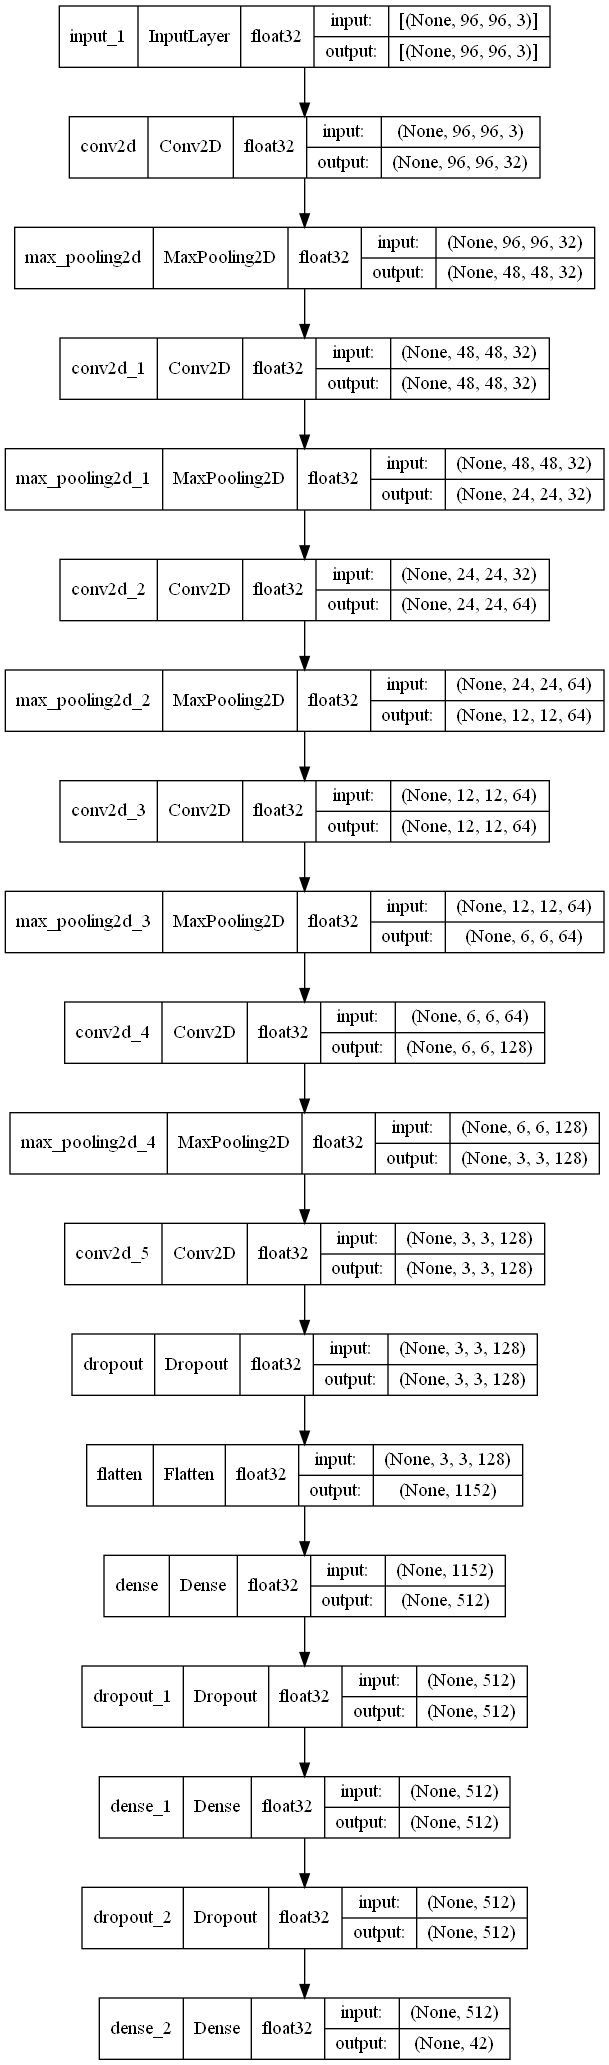

In [7]:
plot_model(exp_conv,
           to_file='../models/exp_conv_4.png',
           show_shapes=True,
           show_dtype=True,
           show_layer_names=True)

In [8]:
exp_conv.compile(optimizer=Adam(learning_rate=0.001),
                 loss=binary_crossentropy,
                 metrics=[Recall(), Precision(), 'accuracy', AUC()])

history = exp_conv.fit(train_gen,
                       epochs=200,
                       validation_data=val_gen,
                       callbacks=[check_pointer, early_stop, reduce_lr],
                       shuffle=True)

Epoch 1/200
609/609 [==============================] - 128s 196ms/step - loss: 0.1564 - recall: 0.1289 - precision: 0.5670 - accuracy: 0.1661 - auc: 0.8123 - val_loss: 0.1305 - val_recall: 0.2399 - val_precision: 0.7250 - val_accuracy: 0.1826 - val_auc: 0.8789 - lr: 0.0010
Epoch 2/200
609/609 [==============================] - 133s 218ms/step - loss: 0.0931 - recall: 0.4292 - precision: 0.7936 - accuracy: 0.2658 - auc: 0.9510 - val_loss: 0.0862 - val_recall: 0.4953 - val_precision: 0.7780 - val_accuracy: 0.2910 - val_auc: 0.9591 - lr: 0.0010
Epoch 3/200
609/609 [==============================] - 132s 216ms/step - loss: 0.0707 - recall: 0.5624 - precision: 0.8285 - accuracy: 0.3135 - auc: 0.9739 - val_loss: 0.0660 - val_recall: 0.6071 - val_precision: 0.8284 - val_accuracy: 0.3229 - val_auc: 0.9778 - lr: 0.0010
Epoch 4/200
609/609 [==============================] - 130s 214ms/step - loss: 0.0580 - recall: 0.6503 - precision: 0.8493 - accuracy: 0.3543 - auc: 0.9828 - val_loss: 0.0496 - v

In [9]:
exp_conv.evaluate(val_gen)

148/148 [==============================] - 4s 25ms/step - loss: 0.0127 - recall: 0.9398 - precision: 0.9592 - accuracy: 0.5516 - auc: 0.9983


[0.012665235437452793,
 0.9398074746131897,
 0.9591881036758423,
 0.5515709519386292,
 0.9982721209526062]

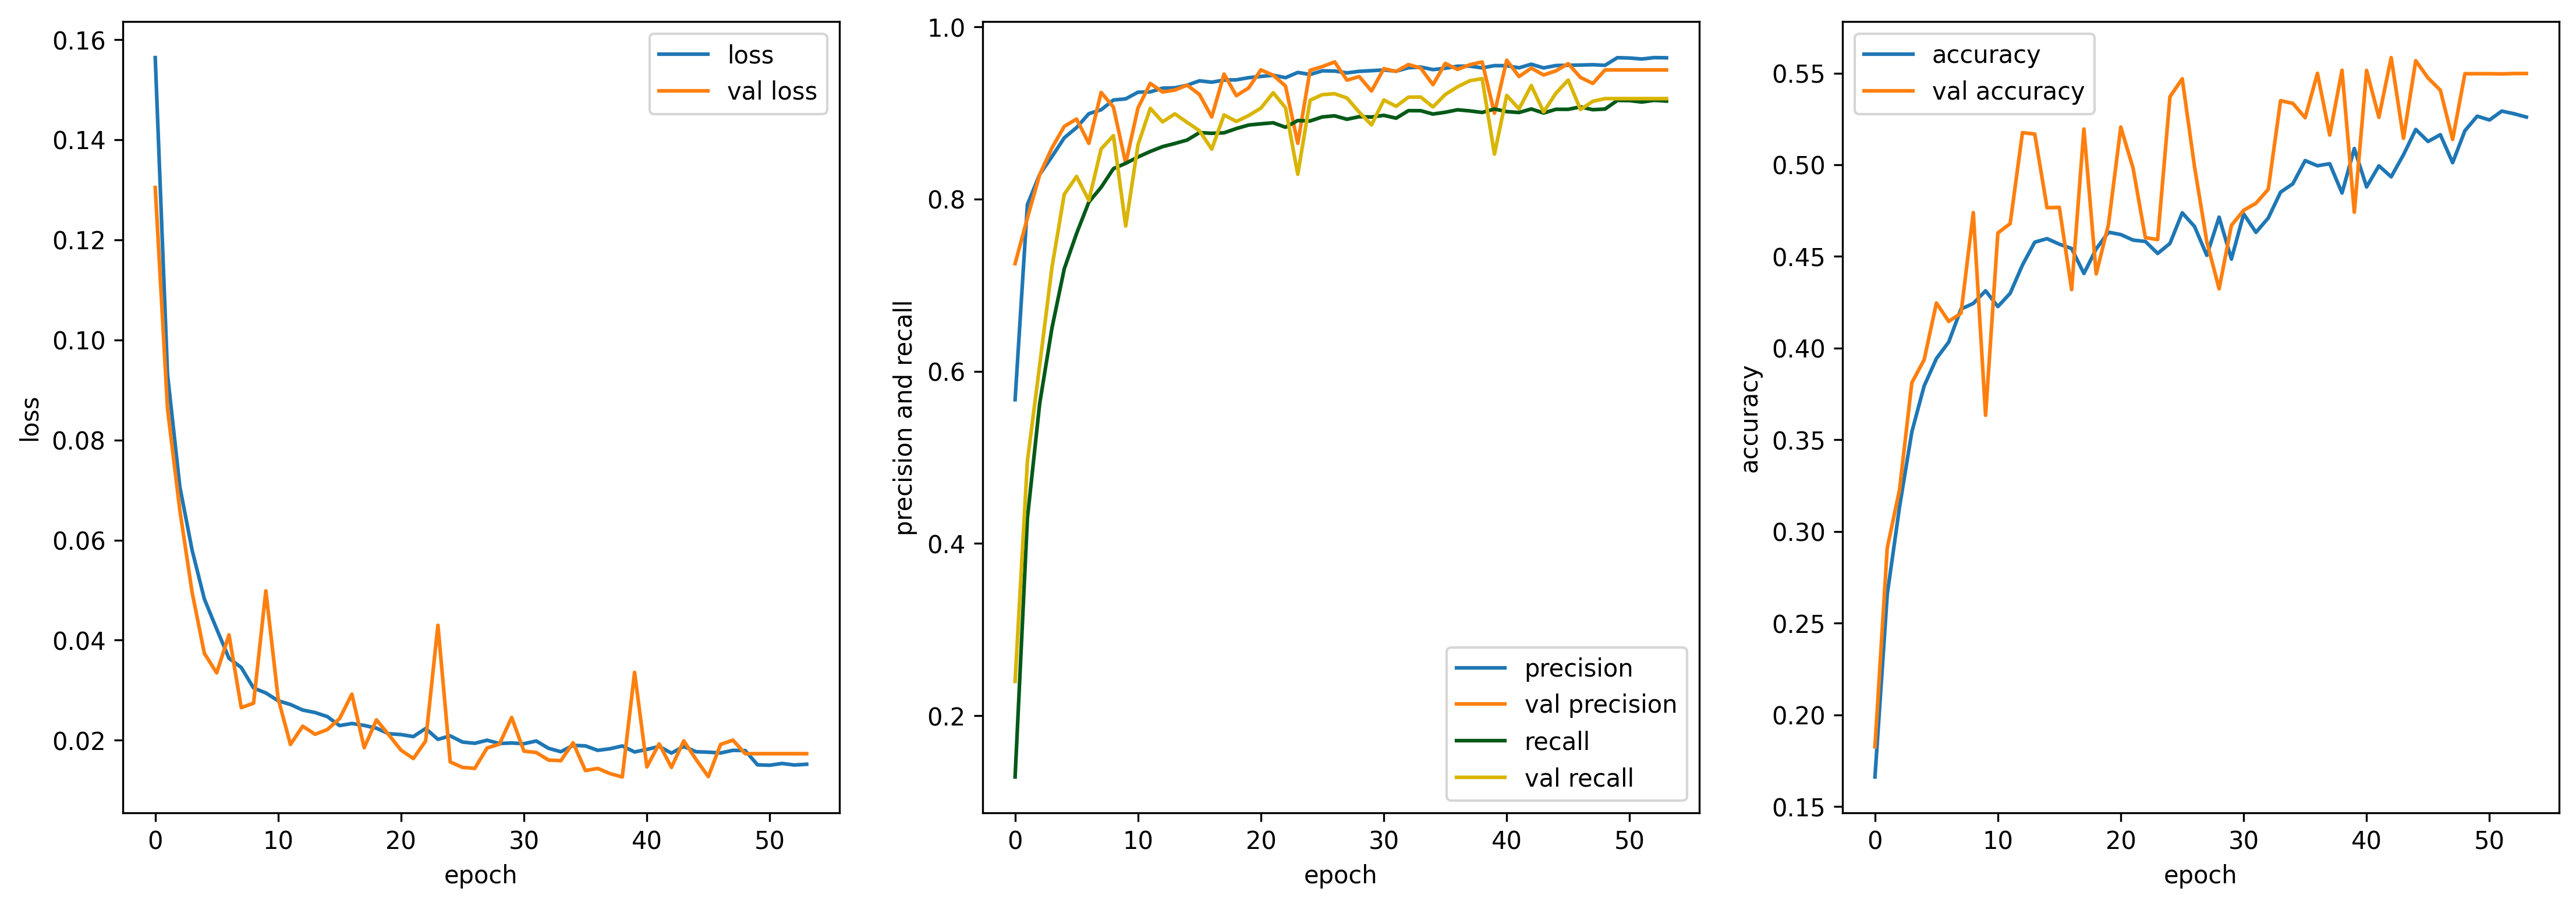

In [11]:
figure, axes = plt.subplots(nrows=1, ncols=3, figsize=[18, 6], dpi=300)
axes = axes.ravel()
epochs = list(range(54))

sns.lineplot(x=epochs, y=history.history['loss'], ax=axes[0], label='loss')
sns.lineplot(x=epochs, y=history.history['val_loss'], ax=axes[0], label='val loss')
sns.lineplot(x=epochs, y=history.history['precision'], ax=axes[1], label='precision')
sns.lineplot(x=epochs, y=history.history['val_precision'], ax=axes[1], label='val precision')
sns.lineplot(x=epochs, y=history.history['recall'], color='#025918', ax=axes[1], label='recall')
sns.lineplot(x=epochs, y=history.history['val_recall'], color='#D9B504', ax=axes[1], label='val recall')
sns.lineplot(x=epochs, y=history.history['accuracy'], ax=axes[2], label='accuracy')
sns.lineplot(x=epochs, y=history.history['val_accuracy'], ax=axes[2], label='val accuracy')
axes[0].set_xlabel('epoch')
axes[0].set_ylabel('loss')
axes[1].set_xlabel('epoch')
axes[1].set_ylabel('precision and recall')
axes[2].set_xlabel('epoch')
axes[2].set_ylabel('accuracy')
plt.savefig('exp_1_1_conv_train_history.png')
plt.show()

In [ ]:
# Plot confusion matrix
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=[36, 36], dpi=300)
axes = axes.ravel()

for i, (label, matrix) in enumerate(zip(mlb.classes_, confusion)):
    labels = [f'not_{label}', label]
    sns.heatmap(matrix, annot=True, square=True, fmt='d', cbar=False, cmap='Blues',
                xticklabels=labels, yticklabels=labels, linecolor='black', linewidth=1,
                ax=axes[i])
    axes[i].set_title(labels[0])

plt.savefig('../model/baseline_cm.png')
plt.show()